In [11]:
import matplotlib.pyplot as plt
import random
import math
import numpy as np
import heapq # Required for the reverse Dijkstra search
%matplotlib inline

# For interactive plots in Jupyter
%config InlineBackend.close_figures = False
plt.ion()
# --- Reusing Helper Classes ---
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0.0 # g-score (from start)
        self.h_val = float('inf') # AIT Specific: Computed heuristic (to goal)
        self.children = []
        
    def __lt__(self, other):
        # Needed for heapq comparisons
        return self.h_val < other.h_val

class Obstacle:
    def __init__(self, x, y, w, h):
        self.x, self.y = x, y
        self.w, self.h = w, h
    
    def contains(self, point):
        px, py = point
        return (self.x <= px <= self.x + self.w) and (self.y <= py <= self.y + self.h)

    def plot(self, ax):
        rect = plt.Rectangle((self.x, self.y), self.w, self.h, color='black')
        ax.add_patch(rect)

# --- AIT* Implementation ---

class AITStar:
    def __init__(self, max_iters=500, batch_size=100, search_space = (-2, -2, 12, 12)):
        self.max_iters = int(max_iters)
        self.batch_size = batch_size
        self.goal_threshold = 0.5
        self.search_space = search_space 
        
        # Plotting setup
        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        
        self.nodes = []       # The Forward Tree (V_tree)
        self.samples = []     # All samples (V_samples)
        self.obstacles = []
        self.path = []
        
        # Search limits
        self.x_min, self.y_min = self.search_space[0], self.search_space[1]
        self.x_max, self.y_max = self.search_space[2], self.search_space[3]
        
        self.c_best = float('inf') 
        self.c_min = 0.0           
        self.start_node = None
        self.goal_node = None
        self.radius = 2.5 # Slightly larger radius helps AIT* heuristic propagation

    def add_obstacle(self, obstacle):
        self.obstacles.append(obstacle)

    def euclid_distance(self, x1, x2, y1, y2):
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def line_intersects_obstacle(self, x1, y1, x2, y2, obstacle):
        steps = 10 
        for i in range(steps + 1):
            t = i / steps
            x = x1 + t * (x2 - x1)
            y = y1 + t * (y2 - y1)
            if obstacle.contains((x, y)):
                return True
        return False

    def collision_free(self, x1, y1, x2, y2):
        for obs in self.obstacles:
            if self.line_intersects_obstacle(x1, y1, x2, y2, obs):
                return False
        return True

    def build_path(self, node):
        path = []
        curr = node
        while curr is not None:
            path.append((curr.x, curr.y))
            curr = curr.parent
        return path[::-1]

    # --- AIT* SPECIFIC: REVERSE HEURISTIC UPDATE ---
    
    def update_reverse_heuristics(self):
        """
        This is the heart of AIT*.
        We run a Dijkstra search starting from the GOAL backwards through 
        all samples to compute a topological heuristic (h_val).
        
        Asymmetric Logic:
        1. We consider edges based on radius.
        2. We do NOT check collisions here (Optimistic approximation).
           This makes the heuristic calculation very fast.
        """
        # 1. Reset Heuristics
        for s in self.samples:
            s.h_val = float('inf')
        self.start_node.h_val = float('inf')
        
        # Goal is the "source" of the reverse search
        self.goal_node.h_val = 0.0
        
        # Priority Queue for Dijkstra
        # (h_val, node_object) - node object needs __lt__ or we use id
        pq = [(0.0, self.goal_node)]
        
        # We need to treat start_node and goal_node as part of the samples temporarily
        all_points = self.samples + [self.start_node, self.goal_node]
        
        # To avoid O(N^2) every frame, a real implementation uses a KD-Tree.
        # For this demo size (N<500), a loop is acceptable.
        
        visited = set()
        
        while pq:
            current_h, curr_node = heapq.heappop(pq)
            
            if curr_node in visited:
                continue
            visited.add(curr_node)
            
            # Find neighbors within radius (Geometric Graph)
            # Optimistic: No collision check here!
            for other in all_points:
                if other == curr_node: continue
                
                dist = self.euclid_distance(curr_node.x, other.x, curr_node.y, other.y)
                
                if dist <= self.radius:
                    new_h = current_h + dist
                    if new_h < other.h_val:
                        other.h_val = new_h
                        heapq.heappush(pq, (new_h, other))

    def get_ait_cost(self, node):
        """Total estimated cost = g (actual) + h (computed reverse)"""
        return node.cost + node.h_val

    # --- SAMPLING ---
    
    def sample_batch(self, start_node, goal_node):
        new_samples = []
        x_center = (start_node.x + goal_node.x) / 2.0
        y_center = (start_node.y + goal_node.y) / 2.0
        angle = math.atan2(goal_node.y - start_node.y, goal_node.x - start_node.x)
        
        if self.c_best == float('inf'):
            for _ in range(self.batch_size):
                rn_x = random.uniform(self.x_min, self.x_max)
                rn_y = random.uniform(self.y_min, self.y_max)
                new_samples.append(Node(rn_x, rn_y))
        else:
            # Informed Sampling (Ellipse)
            c_min = self.c_min
            c_max = self.c_best
            if c_max < c_min + 1e-6: c_max = c_min + 1e-6

            r1 = c_max / 2.0 
            r2 = math.sqrt(c_max**2 - c_min**2) / 2.0
            
            C = np.array([[math.cos(angle), -math.sin(angle)], 
                          [math.sin(angle),  math.cos(angle)]])
            L = np.diag([r1, r2])
            
            for _ in range(self.batch_size):
                x_ball, y_ball = random.uniform(-1, 1), random.uniform(-1, 1)
                while x_ball**2 + y_ball**2 > 1:
                    x_ball, y_ball = random.uniform(-1, 1), random.uniform(-1, 1)
                
                pt = np.dot(C, np.dot(L, np.array([x_ball, y_ball])))
                new_samples.append(Node(pt[0] + x_center, pt[1] + y_center))
                
        return new_samples

    def prune(self):
        if self.c_best == float('inf'): return
        
        # AIT* Pruning:
        # We can prune samples if their (heuristic_start + heuristic_goal) > c_best
        # Note: self.start_node.h_val is effectively distance to goal via samples
        # But for pruning, we usually use the Admissible Euclidean to be safe.
        
        self.samples = [n for n in self.samples 
                        if (self.euclid_distance(self.start_node.x, n.x, self.start_node.y, n.y) + 
                            self.euclid_distance(n.x, self.goal_node.x, n.y, self.goal_node.y)) < self.c_best]

        self.nodes = [n for n in self.nodes 
                      if (n.cost + self.euclid_distance(n.x, self.goal_node.x, n.y, self.goal_node.y)) < self.c_best]

    # --- PLOTTING ---
    def plot_tree(self, start, goal, final_path=False):
        self.ax.clear()
        self.ax.set_xlim(self.search_space[0], self.search_space[2])
        self.ax.set_ylim(self.search_space[1], self.search_space[3])
        self.ax.set_aspect('equal')
        self.ax.grid(True)
        
        for obs in self.obstacles:
            obs.plot(self.ax)

        # Plot Samples colored by Heuristic Value
        if self.samples:
            sx = [n.x for n in self.samples]
            sy = [n.y for n in self.samples]
            # Color map based on h_val to visualize the "Potential Field"
            h_vals = [min(n.h_val, 20) for n in self.samples] # Cap at 20 for visual consistnecy
            self.ax.scatter(sx, sy, c=h_vals, cmap='viridis_r', s=10, alpha=0.6, label='Samples (H-val)')

        # Plot Edges
        for node in self.nodes:
            if node.parent:
                self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], 'b-', alpha=0.3)

        self.ax.plot(start.x, start.y, 'go', markersize=10, label='Start')
        self.ax.plot(goal.x, goal.y, 'ro', markersize=10, label='Goal')

        if self.c_best != float('inf'):
            angle = math.atan2(goal.y - start.y, goal.x - start.x)
            center = ((start.x + goal.x)/2, (start.y + goal.y)/2)
            width = self.c_best
            height = math.sqrt(max(0, self.c_best**2 - self.c_min**2))
            ellipse = plt.matplotlib.patches.Ellipse(
                center, width, height, angle=math.degrees(angle), 
                fill=False, color='orange', linestyle='--', linewidth=2
            )
            self.ax.add_patch(ellipse)

        if self.path:
            px = [p[0] for p in self.path]
            py = [p[1] for p in self.path]
            self.ax.plot(px, py, 'g-', linewidth=3, label='Current Best')

        plt.title(f"AIT* | Cost: {self.c_best:.2f} | Nodes: {len(self.nodes)}")
        plt.draw()
        plt.pause(0.01)

    # --- MAIN LOOP ---
    def run(self, start_pos, goal_pos, stop_on_first=True, visualize=False):
        self.start_node = Node(start_pos[0], start_pos[1])
        self.goal_node = Node(goal_pos[0], goal_pos[1])
        
        self.nodes = [self.start_node]
        self.samples = [] 
        self.c_min = self.euclid_distance(start_pos[0], goal_pos[0], start_pos[1], goal_pos[1])
        self.c_best = float('inf')
        self.path = []
        
        for i in range(self.max_iters):
            
            self.prune()
            
            # 1. Sample
            new_batch = self.sample_batch(self.start_node, self.goal_node)
            self.samples.extend(new_batch)
            
            # 2. AIT* Update: Compute Reverse Heuristics
            # This assigns an 'h_val' to every sample based on connectivity
            # print("Updating Reverse Heuristics...")
            self.update_reverse_heuristics()
            
            # 3. Expansion Step
            # Sort samples by AIT cost (g_est + h_ait)
            # We estimate g_est as straight line from start (lower bound)
            self.samples.sort(key=lambda n: 
                 self.euclid_distance(self.start_node.x, n.x, self.start_node.y, n.y) + n.h_val
            )
            
            current_tree = list(self.nodes)
            
            # Sort tree nodes by f-score (g + h_ait)
            current_tree.sort(key=lambda n: n.cost + n.h_val)

            for tree_node in current_tree:
                
                # Check neighbors
                neighbors = []
                for sample in self.samples:
                    dist = self.euclid_distance(tree_node.x, sample.x, tree_node.y, sample.y)
                    if dist <= self.radius:
                        neighbors.append((dist, sample))
                
                for dist, sample in neighbors:
                    new_cost = tree_node.cost + dist
                    
                    # Use AIT Heuristic (h_val) for admissibility check
                    # If g + h_ait < c_best, it's worth exploring
                    if new_cost + sample.h_val < self.c_best:
                        
                        # Strict collision check ONLY happens here (Forward search)
                        if self.collision_free(tree_node.x, tree_node.y, sample.x, sample.y):
                            
                            if sample in self.samples:
                                self.samples.remove(sample)
                                sample.parent = tree_node
                                sample.cost = new_cost
                                self.nodes.append(sample)

                                if len(self.nodes) % 10 == 0 and visualize:
                                    self.plot_tree(self.start_node, self.goal_node)

                                # Check Goal
                                dist_to_goal = self.euclid_distance(sample.x, self.goal_node.x, sample.y, self.goal_node.y)
                                if dist_to_goal < self.goal_threshold:
                                    total_cost = new_cost + dist_to_goal
                                    
                                    if total_cost < self.c_best:
                                        self.c_best = total_cost
                                        self.goal_node.parent = sample
                                        self.path = self.build_path(self.goal_node)
                                        # print(f"Path Found! Cost: {self.c_best:.2f}")
                                        
                                        if stop_on_first:
                                            if visualize:
                                                self.plot_tree(self.start_node, self.goal_node, final_path=True)
                                            return True, self.path

            if i % 2 == 0 and visualize:
                self.plot_tree(self.start_node, self.goal_node)

        return (self.c_best != float('inf')), self.path

    def run_with_map_config(self, map_config, visualize=False):
        """
        Wrapper: Sets up the environment and calls the core run method.
        """
        # 1. Reinitialize Class Variables based on Map Config
        self.search_space = map_config['bounds']
        self.obstacles = map_config['obstacles']
        self.nodes = [] # Clear previous tree
        
        # 2. Extract Start and Goal
        start = map_config['start']
        goal = map_config['goal']
        
        # 3. Call the core logic
        return self.run(start, goal, visualize=visualize)

Final Path Length: 10


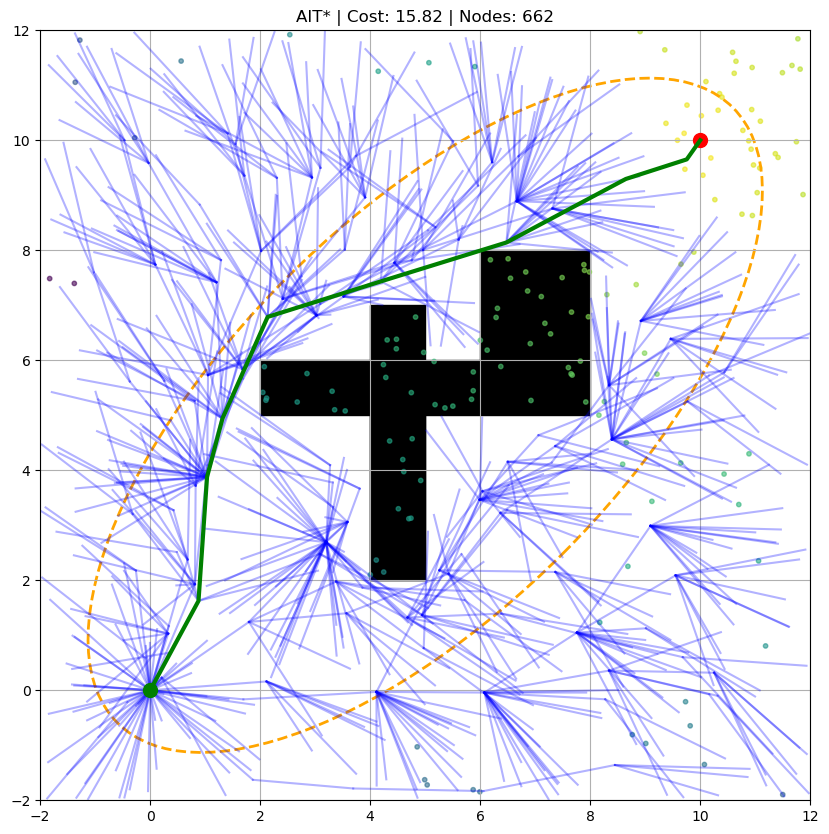

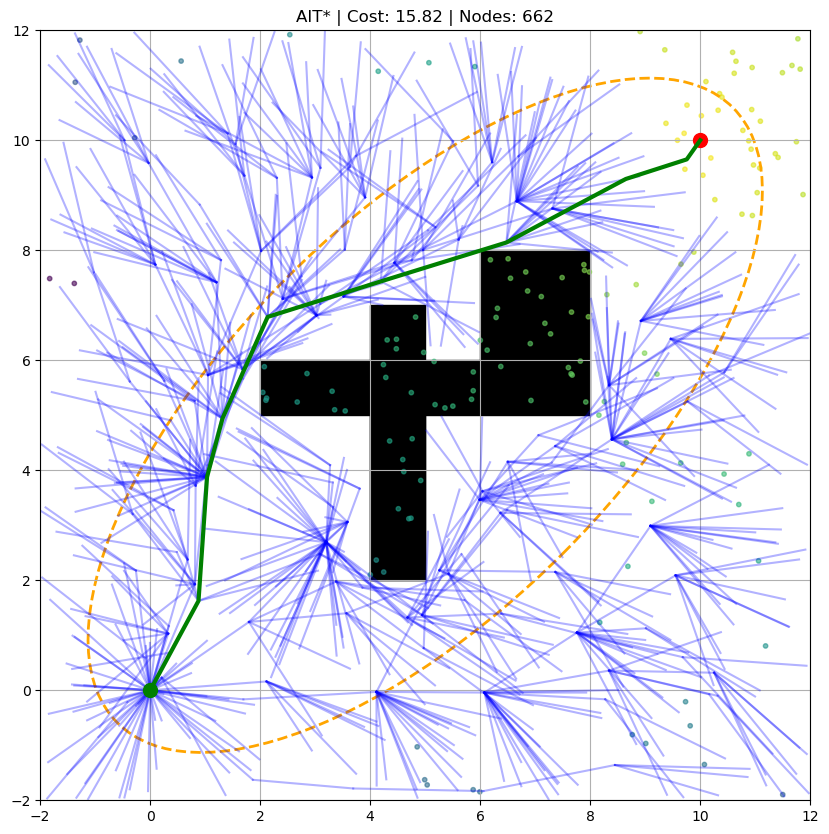

In [12]:
# --- EXECUTION ---

ait = AITStar(max_iters=50, batch_size=100)

# Same obstacles
ait.add_obstacle(Obstacle(4, 2, 1, 5))
ait.add_obstacle(Obstacle(4, 2, 1, 3))
ait.add_obstacle(Obstacle(2, 5, 6, 1))
ait.add_obstacle(Obstacle(6, 6, 2, 2))

# Use AIT* 
success, path = ait.run([0, 0], [10, 10], stop_on_first=True)

if success:
    print(f"Final Path Length: {len(path)}")
    ait.plot_tree(ait.start_node, ait.goal_node, final_path=True)
    plt.show()
else:
    print("Failed to find path.")